# CIFAR-10 Image Classification using TensorFlow

In [1]:
import numpy as np
import pandas as pd
import tarfile
import pickle
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
file_path = 'input/cifar-10-python.tar.gz' 
extracted_path = 'working/cifar-10-batches-py'

with tarfile.open(file_path, 'r:gz') as tar: tar.extractall(path='working/')

C:\Users\amrali\AppData\Local\Temp\ipykernel_7492\3387314499.py:4: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  with tarfile.open(file_path, 'r:gz') as tar: tar.extractall(path='working/')


In [3]:
def load_batch(batch_filename): 
    with open(batch_filename, 'rb') as file: 
        batch = pickle.load(file, encoding='latin1') 
    data = batch['data'] 
    labels = batch['labels']
    return data, labels

## Dataset
The CIFAR-10 (Canadian Institute for Advanced Research) dataset is a widely used benchmark dataset for image classification tasks. It consists of 60,000 color images of size 32×32 pixels, categorized into 10 different classes. Each class contains 6,000 images, with 50,000 images designated for training and 10,000 images for testing.

- **Number of Classes:** 10  
- **Classes:** Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck  
- **Image Size:** \( 32 * 32 \) pixels  
- **Channels:** 3 (RGB)  
- **Total Images:** 60,000  
- **Training Set:** 50,000 images  
- **Test Set:** 10,000 images  

### **Dataset Shape**
- **Training Data:** \( (50000, 32, 32, 3) \)  
- **Test Data:** \( (10000, 32, 32, 3) \)  
- **Labels Shape:**  
  - TensorFlow/Keras: \( (50000, 1) \) for training, \( (10000, 1) \) for testing  
  - PyTorch: Labels are stored as a **1D tensor** 

In [4]:
data, labels = load_batch("working/cifar-10-batches-py/data_batch_1")
print("data[0]: ", data[0], ", shape: ", data[0].shape)

data[0]:  [ 59  43  50 ... 140  84  72] , shape:  (3072,)


### **Function: `image_redimension`**

This function processes CIFAR-10 images by reshaping, converting them to grayscale, and flattening them into 1D arrays.

#### **Parameters:**
- `data`: A NumPy array of images in the shape `(num_images, 32, 32, 3)`.
- `labels`: Corresponding labels for the images.

#### **Steps:**
1. **Reshape Data**:  
   - Changes the shape from `(num_images, 32, 32, 3)` to `(num_images, 3, 32, 32)`  
   - This follows the format used in deep learning frameworks like PyTorch.

2. **Transpose Dimensions**:  
   - Converts from `(num_images, 3, 32, 32)` to `(num_images, 32, 32, 3)`,  
     making it compatible with OpenCV.

3. **Convert to Grayscale & Flatten**:  
   - Uses OpenCV to convert each RGB image to grayscale.  
   - Flattens the grayscale images into 1D arrays.

#### **Returns:**
- A NumPy array containing the grayscale images in 1D format.
- The unchanged `labels` array.

#### **Example Usage:**
```python
data_gray_1D, new_labels = image_redimension(x_train, y_train)
print(data_gray_1D.shape)  # Expected: (50000, 1024)

In [5]:
def image_redimension(data, labels):
    data = data.reshape((-1, 3, 32, 32)) # num_images x num_channel x width x height
    data = data.transpose(0, 2, 3, 1)    # num_images x width x height x num_channel

    # Convert images to grayscale and flattening them to 1D
    data_gray_1D = [cv.cvtColor(img, cv.COLOR_BGR2GRAY).flatten() for img in data]

    return np.array(data_gray_1D), labels

In [6]:
def show_examples(data, labels):
    plt.figure(figsize=(6, 6))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        gray_image = data[i].reshape(32, 32)  # Remodeler les images en 32x32 pour l'affichage car on utilise flatten 
        plt.imshow(gray_image, cmap='gray', interpolation='nearest')
        plt.title(labels[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

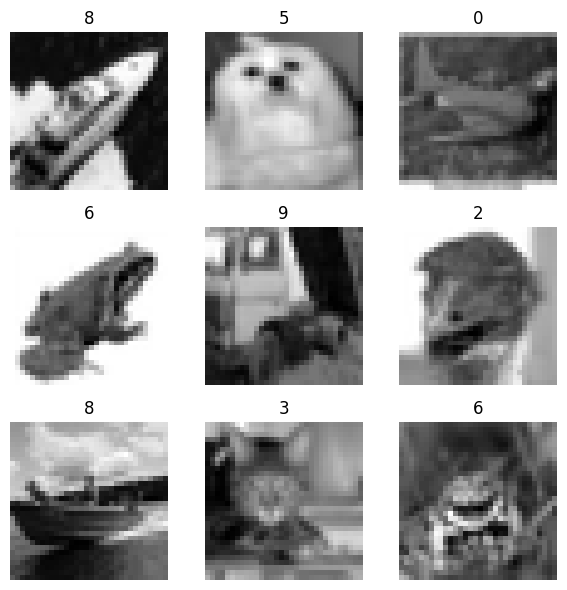

In [7]:
data,labels=load_batch("working/cifar-10-batches-py/data_batch_3")
data,labels=image_redimension(data,labels)
show_examples(data,labels)

In [8]:
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", 
               "Dog", "Frog", "Horse", "Ship", "Truck"]

In [9]:
def show_one_image_per_label(images, labels, class_names):
    unique_classes = np.unique(labels)  # Get unique labels (0-9)
    fig, axes = plt.subplots(2, 5, figsize=(10, 5))  # Create 2x5 grid

    for i, cls in enumerate(unique_classes):
        # Get index of the first image with the current class
        idx = np.where(labels == cls)[0][0]
        sample = images[idx].reshape(32, 32)  # Reshape to 32x32

        ax = axes[i // 5, i % 5]
        ax.imshow(sample, cmap="gray")
        ax.set_title(class_names[cls])  # Use class name
        ax.axis("off")

    plt.tight_layout()
    plt.show()

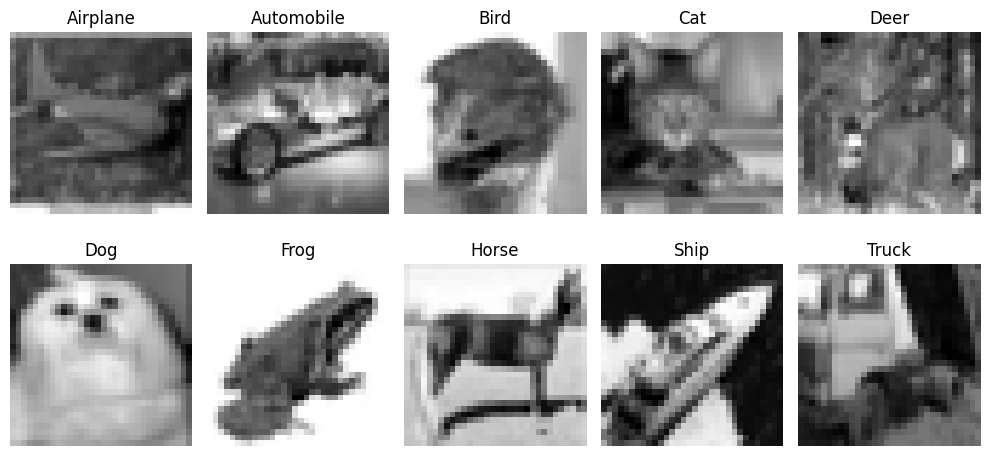

In [10]:
# Display one image per class
show_one_image_per_label(data, labels, class_names)

## Load Dataset

In [11]:
# List of batch file paths
batch_paths = [
    "working/cifar-10-batches-py/data_batch_1",
    "working/cifar-10-batches-py/data_batch_2",
    "working/cifar-10-batches-py/data_batch_3",
    "working/cifar-10-batches-py/data_batch_4"
]

# Function to load and preprocess all batches
def load_and_preprocess_batches(batch_paths):
    all_data, all_labels = [], []
    
    for path in batch_paths:
        data, labels = load_batch(path)  # Load batch
        data, labels = image_redimension(data, labels)  # Convert to grayscale & flatten
        all_data.append(data)
        all_labels.append(labels)

    # Concatenate all batches into a single dataset
    return np.vstack(all_data), np.hstack(all_labels)

# Load and preprocess data
data, labels = load_and_preprocess_batches(batch_paths)

## Normalization: 
 - Scale pixel values to the range [0,1] or [-1,1] to improve model training.

In [12]:
def normalize_images(data: np.ndarray) -> np.ndarray:
    """Normalizes pixel values to the range [0, 1]."""
    return data / 255.0  # Vectorized operation for efficiency

In [13]:
data = normalize_images(data)

In [14]:
# Create DataFrame with pixel values
df = pd.DataFrame(data)

# Add labels and class names
df['label'] = labels
df['class_name'] = df['label'].apply(lambda x: class_names[x])  # Map label numbers

In [15]:
# Check class distribution
print(df['class_name'].value_counts())

class_name
Bird          4048
Horse         4023
Frog          4020
Deer          4003
Ship          3997
Automobile    3986
Airplane      3986
Cat           3984
Truck         3978
Dog           3975
Name: count, dtype: int64


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

X_train, X_test, y_train, y_test = X_train.reshape(-1, 32, 32, 1), X_test.reshape(-1, 32, 32, 1),\
                                   y_train, y_test

print("X_train size: ", len(X_train))
print("y_train size: ", len(y_train))
print("X_test size: ", len(X_test))
print("y_test size: ", len(y_test))

X_train size:  32000
y_train size:  32000
X_test size:  8000
y_test size:  8000


# Model

## Overview
This model is a **Convolutional Neural Network (CNN)** designed for image classification using the **CIFAR-10** dataset. The dataset consists of grayscale images of size **(32, 32, 1)** across **10 different classes**.

![Model Diagram](Diagram.png)

## Model Architecture

### Input Layer
- Accepts input images of shape **(32, 32, 1)**.
    - Defines the input layer with shape (32, 32, 1) (height, width, channels).
    - Since the images are grayscale, there is only 1 channel (instead of 3 for RGB).

### Feature Extraction: Convolutional and Pooling Layers
Each Conv2D layer extracts spatial features, followed by Batch Normalization (stabilizes learning) and MaxPooling (reduces dimensions).

1. **Conv Layer 1**: 32 filters, (3×3) kernel, ReLU activation, Batch Normalization, Max Pooling (2×2).
2. **Conv Layer 2**: 64 filters, (3×3) kernel, ReLU activation, Batch Normalization, Max Pooling (2×2).
3. **Conv Layer 3**: 128 filters, (3×3) kernel, ReLU activation, Batch Normalization, Max Pooling (2×2).
4. **Conv Layer 4**: 256 filters, (3×3) kernel, ReLU activation, Batch Normalization, Flatten.

- Conv2D(`n`, (3,3)) → `n` filters of size 3×3 to detect edges, patterns, etc.
- ReLU Activation → Applies max(0, x) to introduce non-linearity.
- Padding='same' → Keeps output size the same as input size.
- Batch Normalization → Normalizes activations for stable learning.
- MaxPooling (2×2) → Reduces spatial size by half, keeping only important features.

### Fully Connected Layers
These layers act as a classifier.

1. **Dense Layer 1**: 512 neurons, ReLU activation, Dropout (50%).
2. **Dense Layer 2**: 256 neurons, ReLU activation, Dropout (25%).
3. **Dense Layer 3**: 128 neurons, ReLU activation, Dropout (50%).

- 512 neurons to process extracted features.
- Dropout (`x%`) → Randomly turns off `x%` of the neurons during training to prevent overfitting.

### Output Layer
- **Dense Layer**: 10 neurons (one for each class), Softmax activation.
    - Softmax activation → Outputs probabilities for each class.

## Compilation
- **Optimizer**: Adam → Adaptive learning rate optimization.
- **Loss Function**: Sparse Categorical Crossentropy → Suitable for multi-class classification with integer labels (0-9).
- **Evaluation Metric**: Accuracy → Used to track model performance.

### Notable Possible Improvements
- **Data Augmentation**: Improve generalization with transformations (rotation, flipping, etc.).
- **More Filters and Layers**: Increase model complexity for better feature extraction.
- **Learning Rate Scheduling**: Reduce learning rate over epochs.
- **Using Transfer Learning**: Pretrained models (e.g., ResNet, VGG) could improve accuracy.

In [17]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

In [18]:
model = Sequential(name="ConvolutionalNeuralNetwork")

model.add(Input(shape=(32, 32, 1)))

# Convolutional Layers
# Layer 1
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2
model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3
model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4
model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Flatten())

# Fully Connected (Dense) Layers
# Layer 1
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.5))

# Layer 2
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.25))

# Layer 3
model.add(Dense(units=128, activation='relu'))

# Output Layer
model.add(Dense(units=10, activation='softmax'))

In [19]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "ConvolutionalNeuralNetwork"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 8, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,652,938 (10.12 MB)

 Trainable params: 2,651,978 (10.12 MB)

 Non-trainable params: 960 (3.75 KB)

### EarlyStopping
- Purpose:

    - Stops training early if the validation loss (or another monitored metric) stops improving for a given number of epochs.
    - Prevents overfitting by stopping training when the model starts to memorize the training data. <br><br><br>

- `monitor='val_loss'`: Watches the validation loss.
- `patience=10`: If the model does not improve for 10 epochs, training stops.
- `restore_best_weights=True`: Loads the best weights (instead of the last ones).

In [21]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=10,           # Stop after 10 epochs with no improvement
    restore_best_weights=True  # Restore best model weights
)

### ModelCheckpoint
- Purpose:

    - Saves the best version of the model during training.
    - Allows you to reload the best model after training (useful if training crashes or overfits). <br><br><br>

- `"best_model.keras"`: The model is saved in HDF5 format.
- `save_best_only=True`: Only saves the model when val_loss improves.
- `mode='min'`: Lower loss is better.

In [22]:
from keras.callbacks import ModelCheckpoint

checkpoint_filepath = "working/best_model.keras"

checkpoint = ModelCheckpoint(
    checkpoint_filepath,       # File to save the best model
    monitor='val_loss',    # Save model when validation loss improves
    save_best_only=True,   # Only keep the best model
    mode='min',            # 'min' because lower loss is better
    verbose=1
)

In [23]:
callbacks = [early_stopping, checkpoint]

## ImageDataGenerator:

1. Creating an ImageDataGenerator for Preprocessing
- Rescale: This is useful to normalize pixel values to the range [0, 1].
- Flow from Numpy Array: You can use `ImageDataGenerator` to directly feed your data to the model in batches from numpy arrays.
2. How to Use `ImageDataGenerator` with Your Data: Assuming you have already reshaped and normalized your input images (or the images are in the correct format), `ImageDataGenerator` can be used to generate batches of data.

### Details on ImageDataGenerator Parameters

- **rescale**: Normalizes image pixels to a desired range (usually [0, 1]).
- **rotation_range**: Random rotations within the given range (in degrees).
- **width_shift_range** and **height_shift_range**: Random shifts along the horizontal or vertical axis.
- **shear_range**: Random shearing transformation.
- **zoom_range**: Random zooming.
- **horizontal_flip**: Randomly flips the images horizontally.

### Steps with ImageDataGenerator

1. **Reshape Data**:  
   Ensure the data is in the format **(batch_size, 32, 32, 1)** for grayscale or **(batch_size, 32, 32, 3)** for RGB.

2. **Normalization**:  
   By using the **rescale** parameter, images can be normalized to the **[0, 1]** range.

3. **Data Augmentation**:  
   Apply transformations like **rotation, zoom, and flips** to augment the dataset.

### Using ImageDataGenerator for Validation and Test Sets

The validation and test sets typically don’t undergo data augmentation. Instead, you can use the **ImageDataGenerator** for rescaling without augmentation:

```python
# Validation generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow(X_val, y_val, batch_size=32)
```

### Advantages of ImageDataGenerator
- **Efficiency**: Automatically handles reshaping and normalization without requiring manual code.
- **Data Augmentation**: Helps improve model generalization by artificially increasing the dataset size using transformations.
- **Easy Integration**: Works seamlessly with Keras fit and fit_generator functions.

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_augmented = ImageDataGenerator(
    # rescale=1./255,         # Normalize pixel values to [0,1]
    rotation_range=20,      # Rotate images by up to 20 degrees
    width_shift_range=0.2,  # Shift horizontally by 20% of width
    height_shift_range=0.2, # Shift vertically by 20% of height
    shear_range=0.15,       # Apply shearing transformations
    zoom_range=0.2,         # Randomly zoom by up to 20%
    horizontal_flip=True,   # Flip images horizontally
    fill_mode='nearest'     # Fill missing pixels after transformations
)

train_generator_augmented = datagen_augmented.flow(X_train, y_train, batch_size=32)

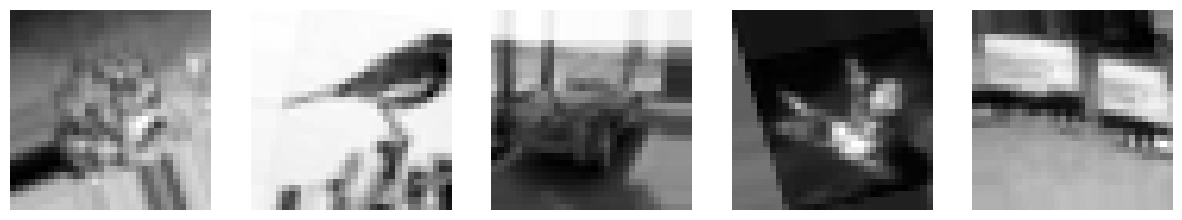

In [27]:
# Get one batch of augmented images
sample_images, _ = train_generator_augmented.__next__()

# Plot some augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(sample_images[i], cmap='gray')  # Show image
    axes[i].axis('off')
plt.show()

# Why These Augmentation Values for CIFAR-10?  

CIFAR-10 consists of **small (32x32) RGB images** across **10 classes**, so augmentations help prevent overfitting and improve model robustness. Here’s why we choose specific values:  

---

## Common Augmentations for CIFAR-10 & Their Reasoning  

| Augmentation        | Typical Value         | Why Use It? |
|--------------------|---------------------|-------------|
| **Rescaling**       | `rescale=1./255`     | Normalizes pixel values to `[0, 1]`, making training more stable. |
| **Rotation**        | `rotation_range=15`  | Small rotations (±15°) add variability while keeping objects recognizable. |
| **Width & Height Shift** | `width_shift_range=0.1`, `height_shift_range=0.1` | Allows slight translations, simulating different viewpoints. |
| **Shear**           | `shear_range=0.2`    | Applies distortions to make the model more robust to shape variations. |
| **Zoom**           | `zoom_range=0.2`     | Adds scale variations, helping the model generalize better. |
| **Horizontal Flip** | `horizontal_flip=True` | Useful for symmetrical objects (e.g., cars, animals), but not for digits/text. |
| **Fill Mode**      | `fill_mode='nearest'` | Fills missing pixels after transformations to avoid artifacts. |


##  Why Not Use Extreme Values?
- **Too much rotation (e.g., 90°)** → May make objects unrecognizable.
- **Large translations (e.g., 0.5 shift)** → Might push important features out of view.
- **Aggressive zoom (e.g., 0.5 zoom)** → Might cut off relevant object parts.
  
By keeping augmentations small but effective, the model learns more diverse representations without destroying important image details.

In [28]:
history = model.fit(
    train_generator_augmented,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=callbacks  # Attach callbacks
)

Epoch 1/100


E:\Code\Python\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2292 - loss: 2.1871
Epoch 1: val_loss improved from inf to 1.59031, saving model to working/best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.2293 - loss: 2.1869 - val_accuracy: 0.4090 - val_loss: 1.5903
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3920 - loss: 1.6896
Epoch 2: val_loss improved from 1.59031 to 1.47529, saving model to working/best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.3920 - loss: 1.6896 - val_accuracy: 0.4656 - val_loss: 1.4753
Epoch 3/100
 999/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4572 - loss: 1.5249
Epoch 3: val_loss improved from 1.47529 to 1.41141, saving model to working/best_model.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.4572 - loss: 1.5249 - val_accuracy: 0.5065 - val_loss: 1.4114
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5028 - loss: 1.4123
Epoch 4: val_l

In [29]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7651 - loss: 0.6941
Loss: 0.6963881850242615, Accuracy: 0.7691249847412109


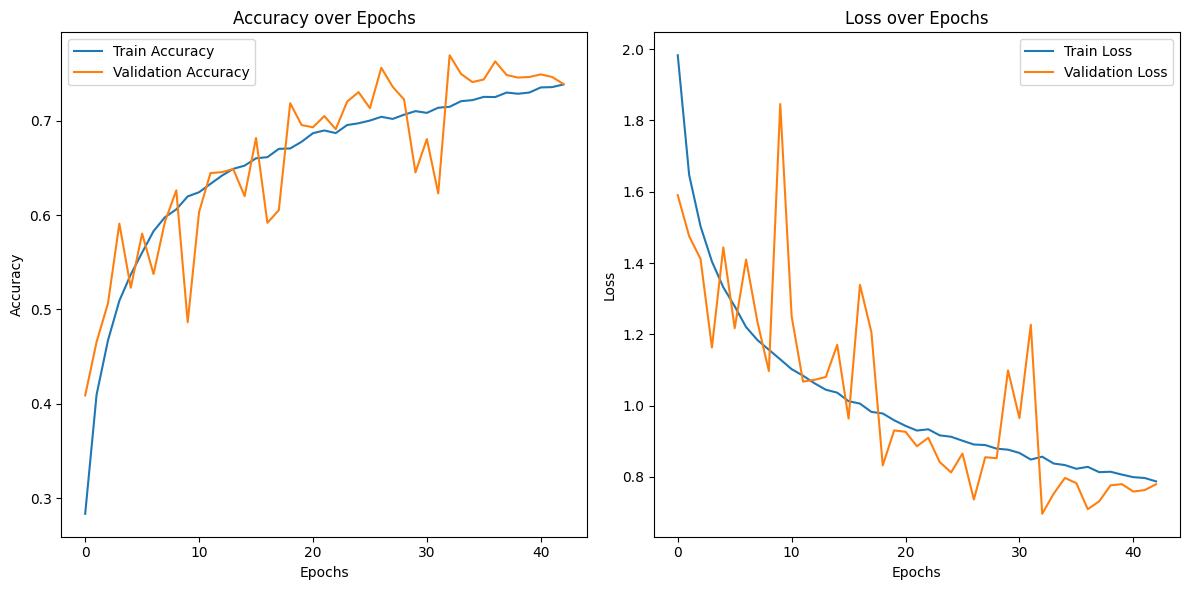

In [30]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_accuracy_loss(history)

In [31]:
test_batch="working/cifar-10-batches-py/test_batch"

x_val, y_val = load_batch(test_batch)

# Resize and convert data to 1D grayscale
x_val, y_val = image_redimension(x_val, y_val)

# Normalize test data
x_val = normalize_images(x_val)  # Assurez-vous de normaliser data_test

# Resize test data to fit model input
x_val = x_val.reshape(-1, 32, 32, 1)

# Make sure the test labels are of type int
y_val = np.array(y_val, dtype='int')

# **Updated Analysis of the Classification Report**

This updated classification report shows an **improvement in model performance**, with the accuracy increasing from **67% to 72%** just by removing the dropout before the softmax layer.

---

## **1. Overall Model Performance**
- **Accuracy: 77%** (previously 67%)  
  - The model now correctly classifies **77% of test images**, which is a notable improvement.
- **Macro Average F1-score: 0.78** (previously 0.66)  
  - This suggests that performance across all classes has improved.
- **Weighted Average F1-score: 0.78** (previously 0.66)  
  - This considers class imbalance, indicating that the model's improvement is consistent across all classes.

---

## **2. Class-Wise Performance**
### **Best-performing classes:**
- **Automobile** (F1-score: **0.90**, Precision: **0.87**, Recall: **0.93**)  
- **Ship** (F1-score: **0.87**, Precision: **0.88**, Recall: **0.87**)  
- **Truck** (F1-score: **0.86**, Precision: **0.89**, Recall: **0.84**)  
  - These classes are well-recognized by the model, with **high recall and precision**.

### **Most improved classes:**
- **Airplane:** F1-score **0.81** (previously **0.64**)  
- **Frog:** F1-score **0.73** (previously **0.71**)  
- **Horse:** F1-score **0.83** (previously **0.73**)  
  - The model is now more accurate in predicting **Airplanes, Frogs, and Horses**, likely due to better feature extraction.

### **Worst-performing classes:**
- **Dog (F1-score: 0.69, Recall: 0.66)**  
- **Cat (F1-score: 0.59, Recall: 0.55)**  
- **Bird (F1-score: 0.64, Recall: 0.55)**  
  - These classes have **low recall**, meaning the model struggles to correctly identify these categories.

In [32]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_val, y_pred_classes, target_names=class_names)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

    Airplane       0.83      0.79      0.81      1000
  Automobile       0.87      0.93      0.90      1000
        Bird       0.78      0.55      0.64      1000
         Cat       0.64      0.55      0.59      1000
        Deer       0.69      0.77      0.73      1000
         Dog       0.72      0.66      0.69      1000
        Frog       0.61      0.91      0.73      1000
       Horse       0.83      0.82      0.83      1000
        Ship       0.88      0.87      0.87      1000
       Truck       0.89      0.84      0.86      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000



In [33]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(x_val, y_val)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7684 - loss: 0.7028
Test Loss: 0.711922824382782, Test Accuracy: 0.7680000066757202


In [34]:
def predict_images(images, labels, class_names, model):
    unique_classes = np.unique(labels)  # Get unique labels (0-9)
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))  # Create 2x5 grid

    for i, cls in enumerate(unique_classes):
        # Get index of the first image with the current class
        idx = np.where(labels == cls)[0][0]
        sample = images[idx].reshape(32, 32, 1)  # Add channel dimension

        # Expand dimensions to match model input shape (1, 32, 32, 1)
        sample = np.expand_dims(sample, axis=0)

        # Predict the image class
        predictions = model.predict(sample)
        predicted_class = np.argmax(predictions)

        ax = axes[i // 5, i % 5]
        ax.imshow(sample[0, :, :, 0], cmap="gray")  # Remove batch and channel dimension for display
        ax.set_title(f"p: {class_names[predicted_class]}, y: {class_names[cls]}")  # Format string correctly
        ax.axis("off")

    # Add a big title above all subplots
    plt.suptitle("Predictions (p) vs Ground Truth (y)", fontsize=16, fontweight="bold")

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


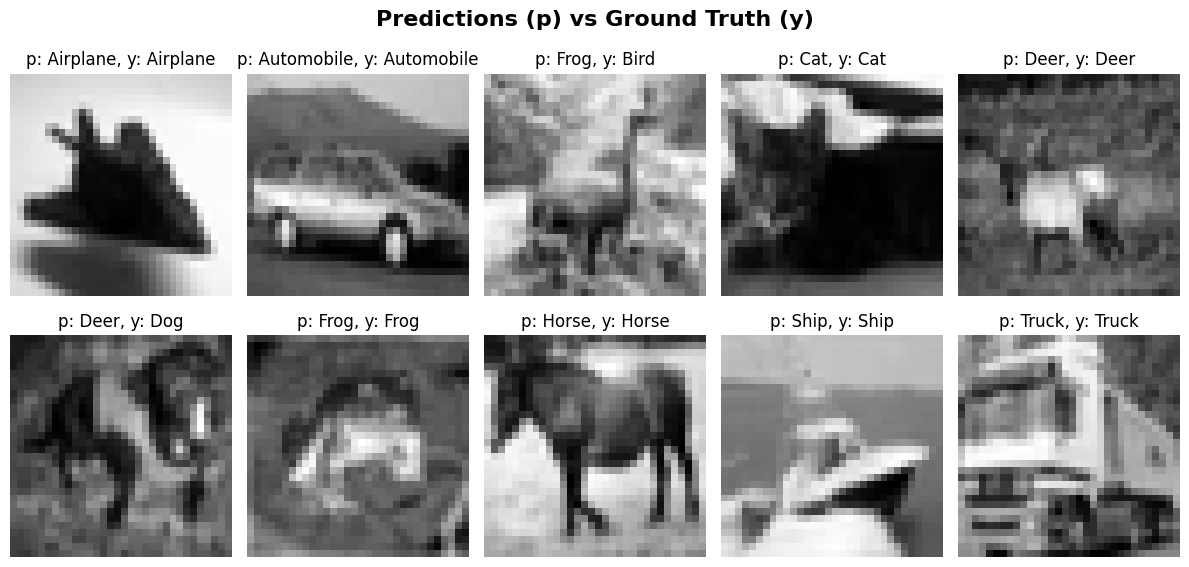

In [35]:
# Predict random images per class
predict_images(data, labels, class_names, model)

## **Insights & Next Steps for Further Improvement**
### **Handling Low Recall in Cats, Dogs, and Birds:**
- Use **more data augmentation** specific to these classes (rotation, zoom, flipping).  
- Consider **focal loss** to give more weight to these underperforming categories.  

### **Further Accuracy Improvements:**
- **More layers or fine-tuning a pre-trained CNN** like **ResNet or EfficientNet** may help.  
- **Regularization techniques (Dropout, BatchNorm tuning)** can be optimized.  
- **Hyperparameter tuning (learning rate, optimizers)** should be experimented with.  

---

## **Conclusion**
- **Performance has improved from 67% → 77% accuracy by improving augmentation.**  
- **Birds, Cats, and Dogs remain the hardest to classify.**  
- **Further improvements can be made with data augmentation, fine-tuning, and regularization techniques.**  